## Load Data

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.integrate import cumulative_trapezoid
from ad99dask import AlexanderDunkerton1999Dask
from constants import GRAV,R_DRY,C_P

## Loon Load

In [2]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = 'data/loon'
u_flux_ptv = []
u_flux_ntv = []
v_flux_ntv = []
v_flux_ptv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv.append(flux[2])    
    v_flux_ptv.append(flux[3])


loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_ntv_v = np.concatenate(v_flux_ntv)
loon_ptv_v = np.concatenate(v_flux_ptv)
loon_abs_v = np.concatenate([np.abs(loon_ntv_v)+np.abs(loon_ptv_v)])
loon_abs_u = np.concatenate([np.abs(loon_ntv_u)+np.abs(loon_ptv_u)])
loon_net_u = np.concatenate([loon_ntv_u+loon_ptv_u])
loon_net_v = np.concatenate([loon_ntv_v+loon_ptv_v])

LOON_DATA = {
    'u_flux_ntv': loon_ntv_u[loon_ntv_u<0],
    'u_flux_ptv': loon_ptv_u[loon_ptv_u>0],
    'v_flux_ntv': loon_ntv_v[loon_ntv_v<0],
    'v_flux_ptv': loon_ptv_v[loon_ptv_v>0],
    'u_flux_abs': loon_abs_u[loon_abs_u>0],
    'v_flux_abs': loon_abs_v[loon_abs_v>0],
    'u_flux_net': loon_net_u,
    'v_flux_net': loon_net_v
}

## Load + Mask Data

In [3]:
## Load in MiMA data
ds = xr.open_dataset('../era5_coarse_daily2015.nc')
## Load Masks
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
ds_mask_trop = ds_mask_trop.rename(lat='latitude',lon='longitude')
interp_mask = ds_mask_trop.interp(latitude=ds.latitude,longitude=ds.longitude,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)

# ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
# ocean_expac = ocean_expac.dropna('points',how='all')
# ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd','omega']]
# ocean_expac = ocean_expac.transpose('time','points','pfull')
# ocean_expac = ocean_expac.isel(pfull=slice(None,None,-1))


# dTdz = da.gradient(ocean_expac.temp,axis=-1)/da.gradient(ocean_expac.height,axis=-1)
# Ns2 = GRAV/ocean_expac.temp*(dTdz + GRAV/C_P) 
# bflim = 1e-4 
# Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
# Ns = np.sqrt(Ns2)
# rho = (100*ocean_expac.pfull.data[None,None,:])/(R_DRY*ocean_expac.temp)

# rho = rho.data.persist()
# lat = ocean_expac.lat.data

# u = ocean_expac.ucomp.data.persist()
# z = ocean_expac.height.data.persist()
# Ns = Ns.data.persist()
# lat = da.broadcast_to(lat,(u.shape[0],u.shape[1])).persist()

In [4]:
ds_points = ds.where(total_mask).stack(points=['latitude','longitude'])
ds_points = ds_points.dropna('points',how='all')
ds_points = ds_points.transpose('time','points','level')
ds_points = ds_points.reset_index('points')


In [5]:
lat = ds_points.latitude.data

# Calibrate AD99 $c_w$ to Loon 
We can always RECENTER by changing the intermittency

In [6]:
cws = np.arange(5,80,5)
level = 70 
i_level = np.argmin(np.abs(ds_points.level.data - level))
i_level

np.int64(27)

In [7]:
u = ds_points.u.data
z = ds_points.z.data 
Ns = ds_points.Ns.data
rho = ds_points.rho.data 


numpy - columnwise

In [8]:
cws = np.arange(5,80,5)

In [62]:
results[0,0,i_level]

array([0.00057513, 0.00033707], dtype=float32)

In [10]:
arr = np.array(results)

In [74]:

for i,c in enumerate(cws):
    np.load(f"data/era_uw_ptv_level70hpa_10degintrinsic_cw_{c}.npy",uw_ptv_level[i])

dask

In [7]:
from dask.diagnostics import ProgressBar
from ad99dask import AlexanderDunkerton1999Dask
uw_ptv_level = []

for c in cws:
    print(c)

    ad99 = AlexanderDunkerton1999Dask(cw=c,dc=0.4,exclude_unbroken=True,use_intrinsic_c='never')
    with ProgressBar():
        _, ptv = ad99.momentum_flux_neg_ptv(u,Ns,z,rho,lat)
        ptv_lvl = ptv[...,i_level].compute().ravel()
    uw_ptv_level.append(ptv_lvl[ptv_lvl > 0])

5
[########################################] | 100% Completed | 238.97 s
10
[########################################] | 100% Completed | 239.64 s
15
[########################################] | 100% Completed | 239.27 s
20
[################################        ] | 80% Completed | 159.18 s


KeyboardInterrupt: 

In [9]:
def variance_and_skew(x):
    mean = np.nanmean(x,axis=-1,keepdims=True)
    var = np.nanmean((x - mean)**2,axis=-1,keepdims=True)
    skew = np.nanmean(((x - mean)/np.sqrt(var))**3,axis=-1)
    return np.squeeze(var,axis=-1),skew


In [10]:
log_var_loon,log_skew_loon = variance_and_skew(np.log10(LOON_DATA['u_flux_ptv']))
var_loon,skew_loon = variance_and_skew(LOON_DATA['u_flux_ptv'])

In [11]:
log_vars = []
log_skews = []
vars = []
skews = []

for i,c in enumerate(cws):
    uw_total_abs = 1000*uw_ptv_level[i]
    log_var,log_skew = variance_and_skew(np.log10(uw_total_abs))
    var,skew = variance_and_skew(uw_total_abs)
    log_vars.append(log_var)
    vars.append(var)
    log_skews.append(log_skew)
    skews.append(skew)

Text(0, 0.5, 'Skew of flux ($mPa^3$)')

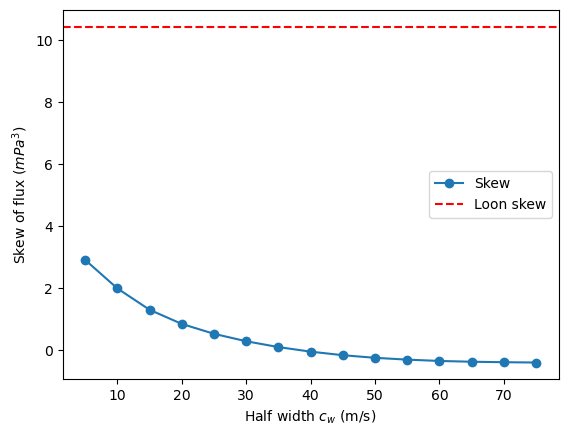

In [12]:
plt.plot(cws,skews,marker='o',label='Skew')
plt.axhline(skew_loon,linestyle='--',color='r',label='Loon skew')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Skew of flux ($mPa^3$)")

Text(0, 0.5, 'Variance of flux ($mPa^2$)')

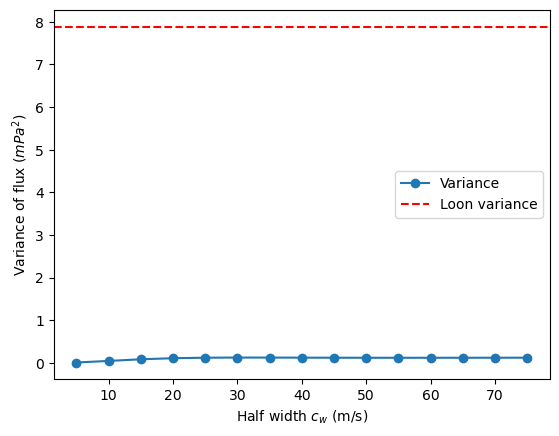

In [13]:
plt.plot(cws,vars,marker='o',label='Variance')
plt.axhline(var_loon,linestyle='--',color='r',label='Loon variance')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Variance of flux ($mPa^2$)")

Text(0, 0.5, 'Skew of log10')

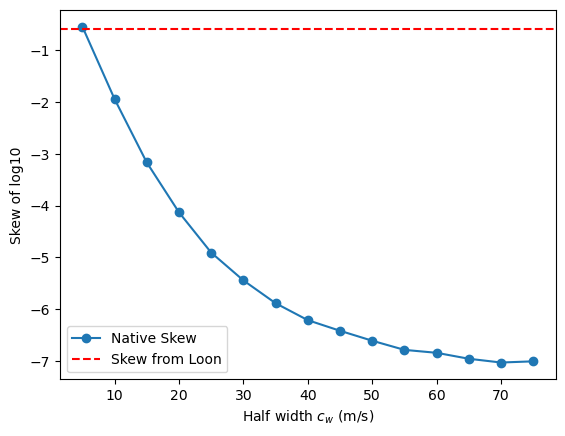

In [14]:
plt.plot(cws,log_skews,marker='o',label='Native Skew')
plt.axhline(log_skew_loon,linestyle='--',color='r',label='Skew from Loon')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Skew of log10")

Text(0, 0.5, 'Variance of log10 flux')

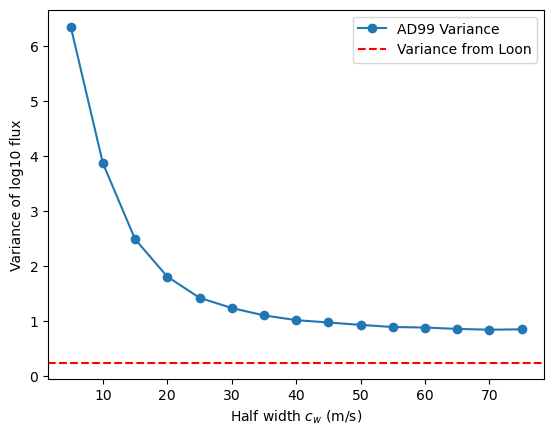

In [15]:
plt.plot(cws,log_vars,marker='o',label='AD99 Variance')
plt.axhline(log_var_loon,linestyle='--',color='r',label='Variance from Loon')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Variance of log10 flux")

Text(0.5, 1.0, 'Log10 (mPa GW stress) - with source intermittency')

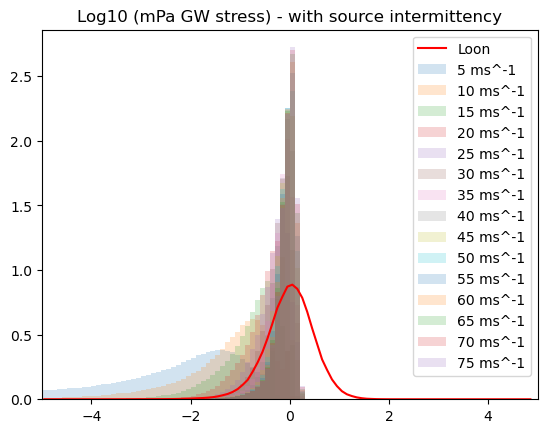

In [16]:
bins = np.arange(-5,5,0.1)  
## LOON
log_loon = np.log10(LOON_DATA['u_flux_ptv'])
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=bins,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')



## Histograms for AD99
for i,c in enumerate(cws):
    uw_total_abs = 1000*uw_ptv_level[i]
    plt.hist(np.log10(uw_total_abs),bins=bins,alpha=0.2,label=f"{c} ms^-1",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.title("Log10 (mPa GW stress) - with source intermittency")

## Adjust mode

In [77]:
def adjust_log_mode(samples): 
    log_samples = np.log10(samples)
    log_samples = log_samples[~np.isnan(log_samples)]
    weights,edges = np.histogram(log_samples,bins=100)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    max_bin = np.argmax(weights)
    mode_bin = bin_centers[max_bin]
    intermittency_factor = 10**(-mode_bin)
    return samples*10**(-mode_bin),intermittency_factor
                

5.278996
2.3943708
1.4175982
1.1574013
0.99645495
0.86876225
0.899746
0.9172726
0.93506724
0.80532163
0.8272438
0.8462791
0.8656611
0.8982373
0.9263181


Text(0, 0.5, 'Skew')

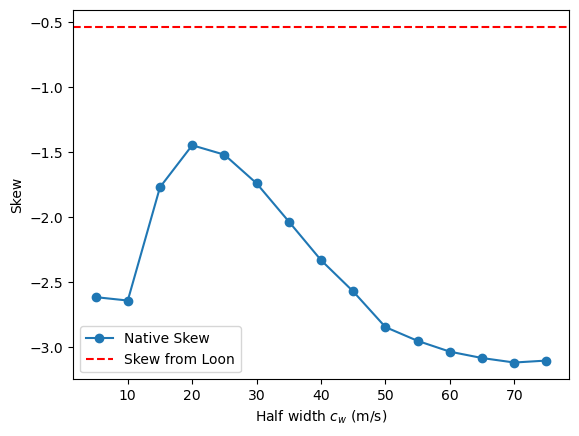

In [78]:
log_vars_recenter = []
log_skews_recenter = []

for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    recenter,eps_adjust = adjust_log_mode(uw_total_abs)
    print(eps_adjust)
    log_var,log_skew = variance_and_skew(np.log10(recenter))

    log_vars_recenter.append(log_var)
    log_skews_recenter.append(log_skew)

plt.plot(cws,log_skews_recenter,marker='o',label='Native Skew')
plt.axhline(log_skew_loon,linestyle='--',color='r',label='Skew from Loon')
plt.xlabel('Half width $c_w$ (m/s)')
plt.legend()
plt.ylabel("Skew")

Text(0.5, 1.0, 'Log10 (mPa GW stress) - Recentered')

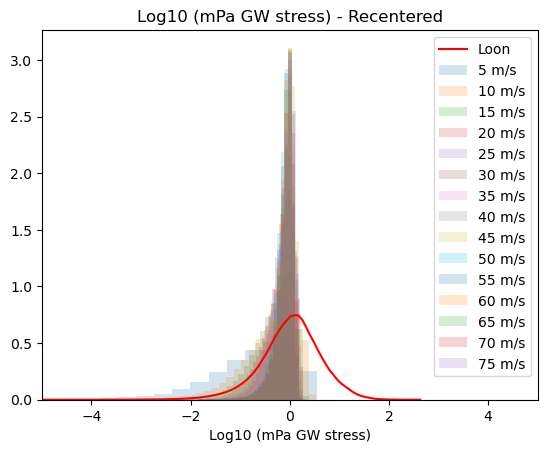

In [79]:
log_loon = np.log10(loon_u_abs)
loon_bin_heights,loon_bin_edges = np.histogram(log_loon[~np.isnan(log_loon)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,label='Loon',color='r')
for i,c in enumerate(cws):
    uw_total = uw_ptvs[i]
    uw_total_abs = np.abs(uw_total[...,i_level])
    uw_total_abs = 1000*uw_total_abs[uw_total_abs > 0]
    recenter,_ = adjust_log_mode(uw_total_abs)
    plt.hist(np.log10(recenter),bins=100,alpha=0.2,label=f"{c} m/s",density=True)
    plt.legend()
plt.xlim(-5,5)
plt.xlabel('Log10 (mPa GW stress)')
plt.title("Log10 (mPa GW stress) - Recentered")